In [221]:
import pandas as pd
import matplotlib.pyplot as plt

file_path = '/Users/HM/Desktop/Code/FOIL_DA_Task-10-2024/data/Online_Retail.xlsx'
df = pd.read_excel(file_path)


In [222]:

def load_data(file_path):

    df = pd.read_excel(file_path)

    df = df.sort_values(by='InvoiceDate').reset_index(drop=True)

    return df.shape, df.head(5), df.info()

In [223]:
print(load_data(file_path))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB
((541909, 8),   InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    5


A large number of CustomerIDs are missing, and will be filled in using 'Missing Description'.

Direct visual inspection of the spreadsheet shows that some items seem to have been mislabeled as other items.

Entries in the Description column are in combination upper- and lower-case, while item names are entirely in upper-case. This does not need to be changed. 

In [224]:
def empty_values(file_path):
    
    
    df = pd.read_excel(file_path)

    cols = ['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate', 'UnitPrice', 'CustomerID', 'Country']
    
    empty_values_count = {}
    
    for col in cols:
        if df[col].dtype == 'object':
            empty_values = df[df[col].isnull() | (df[col].str.strip() == "")]
        else:
            empty_values = df[df[col].isnull()]

        empty_values_count[col] = len(empty_values)

        if len(empty_values) > 0:
            print(f"Column {col} has {len(empty_values)} missing or empty values")
        else:
            print(f"No empty or missing values found in {col} column")
            
    return empty_values_count

print(empty_values(file_path))

No empty or missing values found in InvoiceNo column
No empty or missing values found in StockCode column
Column Description has 1454 missing or empty values
No empty or missing values found in Quantity column
No empty or missing values found in InvoiceDate column
No empty or missing values found in UnitPrice column
Column CustomerID has 135080 missing or empty values
No empty or missing values found in Country column
{'InvoiceNo': 0, 'StockCode': 0, 'Description': 1454, 'Quantity': 0, 'InvoiceDate': 0, 'UnitPrice': 0, 'CustomerID': 135080, 'Country': 0}


Filling empty Customer IDs and Descriptions with suitable values

In [225]:
def fill_missing_cust_id(file_path):

    df = pd.read_excel(file_path)
    prior_missing_cust_ids= df['CustomerID'].isnull().sum()
    df['CustomerID'] = df['CustomerID'].fillna("Missing ID")

    post_missing_cust_ids = df['CustomerID'].isnull().sum()

    return prior_missing_cust_ids, post_missing_cust_ids

In [226]:
def fill_missing_description(file_path):
    
    df = pd.read_excel(file_path)
    
    prior_missing_descriptions = df['Description'].isnull().sum()
    
    df['Description'] = df['Description'].fillna("Missing Description")
    
    post_missing_descriptions = df['Description'].isnull().sum()
    
    df.to_excel(file_path, index=False)
    return prior_missing_descriptions, post_missing_descriptions

In [227]:
for col in ['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate', 'UnitPrice', 'CustomerID', 'Country']:
    print(f"{df[col].isnull().mean() * 100}% of {col} is missing")

0.0% of InvoiceNo is missing
0.0% of StockCode is missing
0.2683107311375157% of Description is missing
0.0% of Quantity is missing
0.0% of InvoiceDate is missing
0.0% of UnitPrice is missing
24.926694334288598% of CustomerID is missing
0.0% of Country is missing


We see there are two columns where values are missing, so we will need to deal with those. We also need to check those values that do not make any sense e.g. negative values for Quantity or UnitPrice.

First, however, we need to drop duplicate rows to prevent double-counting.

In [228]:
def drop_duplicates(file_path):

    df = pd.read_excel(file_path)
    df = df.drop_duplicates()
    
    return df

Next we deal with non-positive prices.

In [229]:
def impute_unit_price(df):
    mask = df['UnitPrice'] <= 0
    for stock_code in df.loc[mask, 'StockCode'].unique():
        positive_prices = df[(df['StockCode'] == stock_code) & (df['UnitPrice'] > 0)]['UnitPrice']
        if not positive_prices.empty:
            mean_positive_price = positive_prices.mean()
            df.loc[(df['StockCode'] == stock_code) & mask, 'UnitPrice'] = mean_positive_price
            
    return df


In [230]:
negative_or_zero_price_percentage = (df['UnitPrice'] <= 0).mean() * 100
print(f"{negative_or_zero_price_percentage:.2f}% of UnitPrice values are zero or negative")


0.46% of UnitPrice values are zero or negative


In [231]:
cleaned_df = impute_unit_price(df)
new_negative_or_zero_price_percentage = (cleaned_df['UnitPrice'] <= 0).mean() * 100
print(f"After imputation, {new_negative_or_zero_price_percentage:.2f}% of UnitPrice values are zero or negative")

After imputation, 0.02% of UnitPrice values are zero or negative


After imputation, we are left with a very small number of negative or zero UnitPrices. 
Because of the impossibility of finding out what these prices should be, we will drop them.

In [232]:
df_no_neg_prices = cleaned_df[df['UnitPrice'] >= 0]
df_no_neg_prices .reset_index(drop=True, inplace=True)
print(df_no_neg_prices)

       InvoiceNo StockCode                          Description  Quantity  \
0         536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1         536365     71053                  WHITE METAL LANTERN         6   
2         536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3         536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4         536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   
...          ...       ...                                  ...       ...   
541904   C581490     23144      ZINC T-LIGHT HOLDER STARS SMALL       -11   
541905   C581499         M                               Manual        -1   
541906   C581568     21258           VICTORIAN SEWING BOX LARGE        -5   
541907   C581569     84978     HANGING HEART JAR T-LIGHT HOLDER        -1   
541908   C581569     20979        36 PENCILS TUBE RED RETROSPOT        -5   

               InvoiceDate  UnitPrice  CustomerID         Country  
0      

In [233]:
negative_quantity = (cleaned_df["Quantity"] <= 0).mean() * 100
print(f"{negative_quantity:.2f}% of Quantity values are zero or negative")

1.96% of Quantity values are zero or negative


Because the cases where Quantity is zero or negative deal with adjustments or outflows, we will ignore that data when looking for the top-selling data and average consumer statistics. 

In [234]:
final_df = cleaned_df[cleaned_df['Quantity'] > 0]

In [235]:
final_df["Country"].value_counts(normalize=True).head(10) * 100

Country
United Kingdom    91.530158
Germany            1.701911
France             1.582578
EIRE               1.485832
Spain              0.467734
Netherlands        0.444771
Belgium            0.382281
Switzerland        0.370234
Portugal           0.282523
Australia          0.223044
Name: proportion, dtype: float64

The UK accounts for almost 92% of all transactions, with the rest being made up of neighbouring EU countries. 

In [236]:
print(f"After cleaning, the first transaction was made at {final_df['InvoiceDate'].min()}")
print(f"The latest transaction was made at {final_df['InvoiceDate'].max()}")
print(f"There were a total of {final_df['InvoiceNo'].nunique()} transactions")

After cleaning, the first transaction was made at 2010-12-01 08:26:00
The latest transaction was made at 2011-12-09 12:50:00
There were a total of 20728 transactions


We can now get a sense of the cleaned data

In [237]:
print(final_df.shape)
print(final_df.info)

(531285, 8)
<bound method DataFrame.info of        InvoiceNo StockCode                          Description  Quantity  \
0         536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1         536365     71053                  WHITE METAL LANTERN         6   
2         536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3         536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4         536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   
...          ...       ...                                  ...       ...   
532616    581587     23255      CHILDRENS CUTLERY CIRCUS PARADE         4   
532617    581587     22138        BAKING SET 9 PIECE RETROSPOT          3   
532618   A563185         B                      Adjust bad debt         1   
532619   A563186         B                      Adjust bad debt         1   
532620   A563187         B                      Adjust bad debt         1   

               InvoiceDate  Uni

We have maintained the same number of columns but reduced the rows containing data we did not need.

In [238]:
summary_stats=final_df.describe()
print(summary_stats)

            Quantity                    InvoiceDate      UnitPrice  \
count  531285.000000                         531285  531285.000000   
mean       10.655262  2011-07-04 18:15:45.816538624       3.956014   
min         1.000000            2010-12-01 08:26:00       0.000000   
25%         1.000000            2011-03-28 11:59:00       1.250000   
50%         3.000000            2011-07-20 12:01:00       2.080000   
75%        10.000000            2011-10-19 12:35:00       4.130000   
max     80995.000000            2011-12-09 12:50:00   13541.330000   
std       156.830323                            NaN      41.827905   

          CustomerID  
count  397924.000000  
mean    15294.315171  
min     12346.000000  
25%     13969.000000  
50%     15159.000000  
75%     16795.000000  
max     18287.000000  
std      1713.169877  


In [239]:
final_df.dtypes

InvoiceNo              object
StockCode              object
Description            object
Quantity                int64
InvoiceDate    datetime64[ns]
UnitPrice             float64
CustomerID            float64
Country                object
dtype: object

In [240]:
final_df.loc[:, 'Amount'] = final_df['Quantity'] * final_df['UnitPrice']

/var/folders/sx/r4jgwl_s61l81xpyqyp51hdr0000gn/T/ipykernel_74510/1586388582.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df.loc[:, 'Amount'] = final_df['Quantity'] * final_df['UnitPrice']


In [241]:
print(final_df[['Quantity', 'UnitPrice', 'Amount']].head(10))

   Quantity  UnitPrice  Amount
0         6       2.55   15.30
1         6       3.39   20.34
2         8       2.75   22.00
3         6       3.39   20.34
4         6       3.39   20.34
5         2       7.65   15.30
6         6       4.25   25.50
7         6       1.85   11.10
8         6       1.85   11.10
9        32       1.69   54.08


In [242]:
print(final_df.isna().sum())

InvoiceNo           0
StockCode           0
Description       592
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     133361
Country             0
Amount              0
dtype: int64


In [243]:
print(final_df.dtypes)

InvoiceNo              object
StockCode              object
Description            object
Quantity                int64
InvoiceDate    datetime64[ns]
UnitPrice             float64
CustomerID            float64
Country                object
Amount                float64
dtype: object


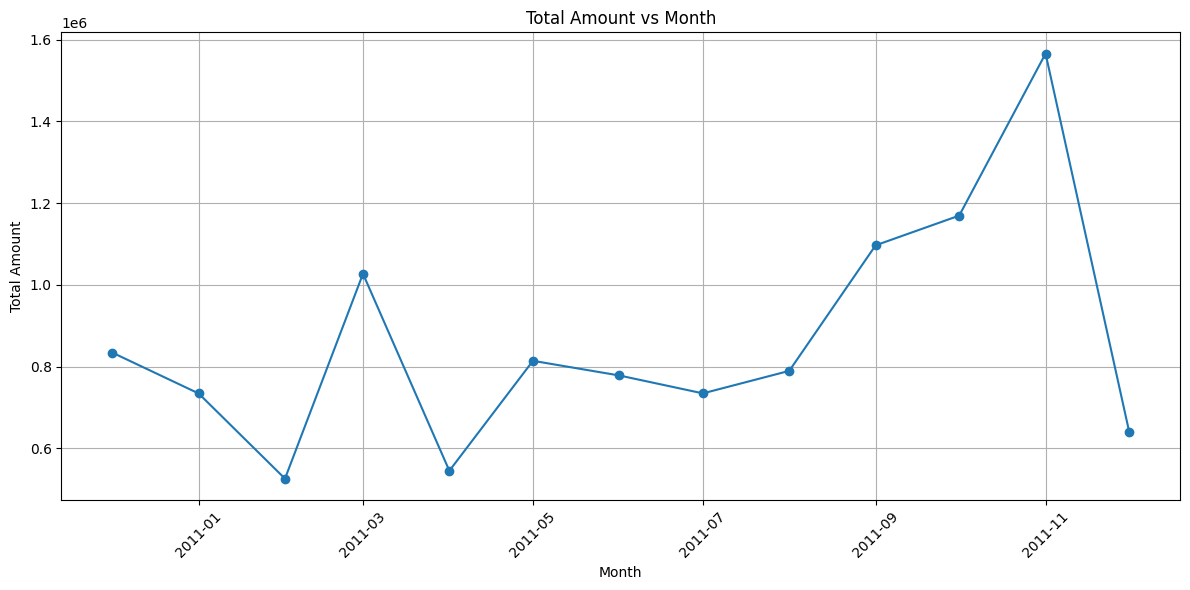

In [250]:
def plot_amount_vs_month(df):
    df = df.assign(InvoiceDate=pd.to_datetime(df['InvoiceDate']))
    df = df.assign(Month=df['InvoiceDate'].dt.to_period('M'))
    
    monthly_amount = df.groupby('Month')['Amount'].sum().reset_index()
    monthly_amount['Month'] = monthly_amount['Month'].dt.to_timestamp()
    
    plt.figure(figsize=(12, 6))
    plt.plot(monthly_amount['Month'], monthly_amount['Amount'], marker='o')
    plt.title('Total Amount vs Month')
    plt.xlabel('Month')
    plt.ylabel('Total Amount')
    plt.xticks(rotation=45)
    plt.grid()
    plt.tight_layout()
    plt.show()

plot_amount_vs_month(final_df)

A rough analysis shows that there was an uptick in sales around the end of 2011. This merits further investigation.

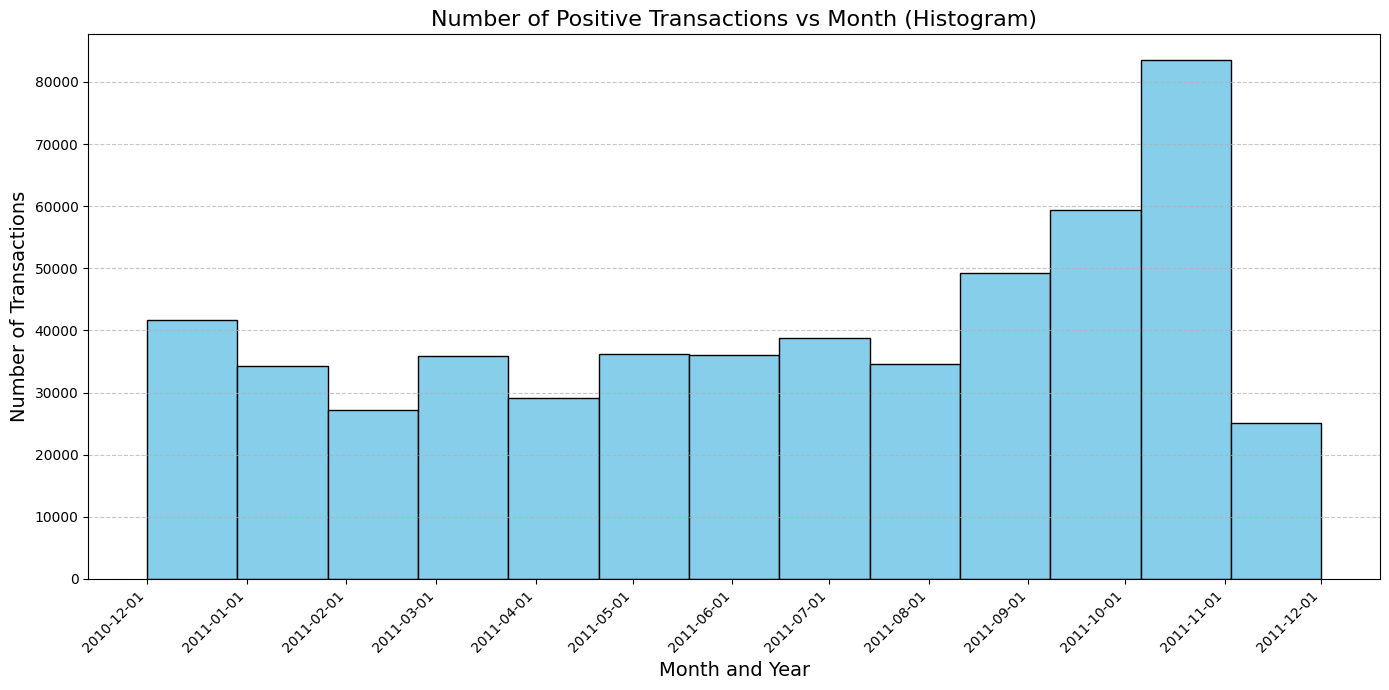

In [248]:

def plot_positive_transactions_histogram(df):
    df = df.assign(InvoiceDate=pd.to_datetime(df['InvoiceDate']))
    df = df.assign(Month=df['InvoiceDate'].dt.to_period('M'))
    
    #The following line is not strictly necessary, but further filters out any returns or cash outflows
    df_positive = df[df['Amount'] > 0]

    
    transactions_per_month = df_positive.groupby('Month').size().reset_index(name='TransactionCount')
    transactions_per_month['Month'] = transactions_per_month['Month'].dt.to_timestamp()

    plt.figure(figsize=(14, 7))
    plt.hist(transactions_per_month['Month'], bins=len(transactions_per_month), weights=transactions_per_month['TransactionCount'], color='skyblue', edgecolor='black')
    
    plt.title('Number of Positive Transactions vs Month (Histogram)', fontsize=16)
    plt.xlabel('Month and Year', fontsize=14)
    plt.ylabel('Number of Transactions', fontsize=14)
    plt.xticks(transactions_per_month['Month'], rotation=45, ha='right', fontsize=10)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

plot_positive_transactions_histogram(final_df)


We can also check the most commonly sold items throughout the year.

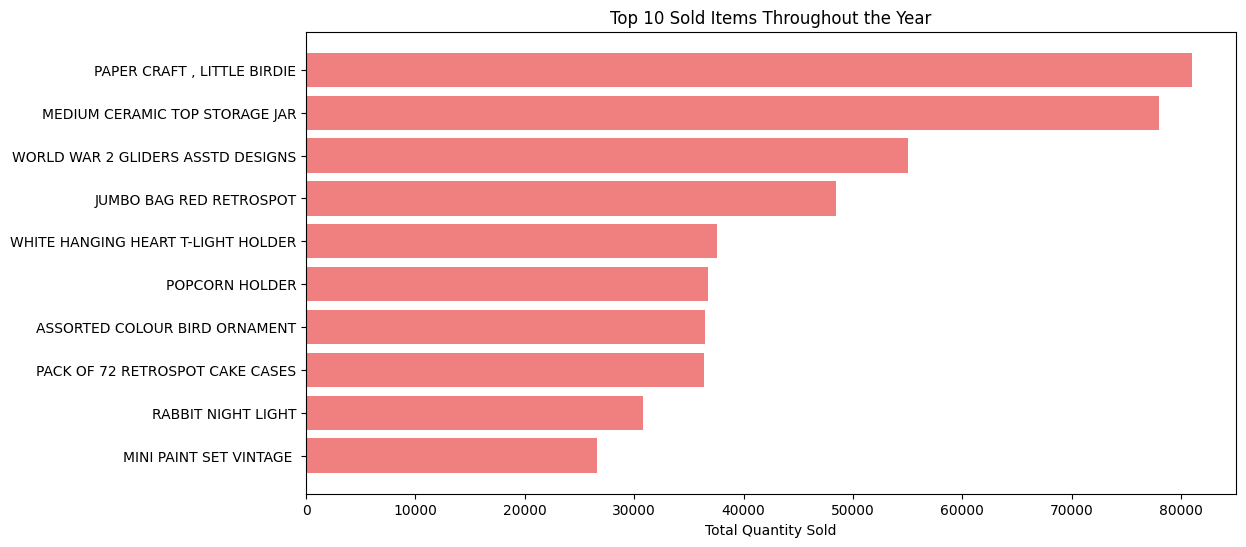

     StockCode                         Description  Quantity
2687     23843         PAPER CRAFT , LITTLE BIRDIE     80995
2131     23166      MEDIUM CERAMIC TOP STORAGE JAR     78033
2879     84077   WORLD WAR 2 GLIDERS ASSTD DESIGNS     55047
3912    85099B             JUMBO BAG RED RETROSPOT     48478
3925    85123A  WHITE HANGING HEART T-LIGHT HOLDER     37603
1103     22197                      POPCORN HOLDER     36761
2985     84879       ASSORTED COLOUR BIRD ORNAMENT     36461
391      21212     PACK OF 72 RETROSPOT CAKE CASES     36419
2028     23084                  RABBIT NIGHT LIGHT     30788
1381     22492             MINI PAINT SET VINTAGE      26633


In [258]:
def get_top_10_sold_items(df):
    df_grouped = df.groupby(['StockCode', 'Description'])['Quantity'].sum().reset_index()
    top_10_sold_items = df_grouped.sort_values(by='Quantity', ascending=False).head(10)
    
    plt.figure(figsize=(12, 6))
    plt.barh(top_10_sold_items['Description'], top_10_sold_items['Quantity'], color='lightcoral')
    plt.xlabel('Total Quantity Sold')
    plt.title('Top 10 Items Sold Throughout the Year')
    plt.gca().invert_yaxis()
    plt.show()
    
    return top_10_sold_items[['StockCode', 'Description', 'Quantity']]

top_10_sold_items = get_top_10_sold_items(final_df)
print(top_10_sold_items)


We see that there is a large amount of variation in the categories of top sellers - however, the consistent top seller is the Paper Craft Little Birdie, followed by the Medium Ceramic Jar. 
We may also want to see if there is any variation in this list around the busiest period of the year i.e. the holiday season (November to December 2021). 

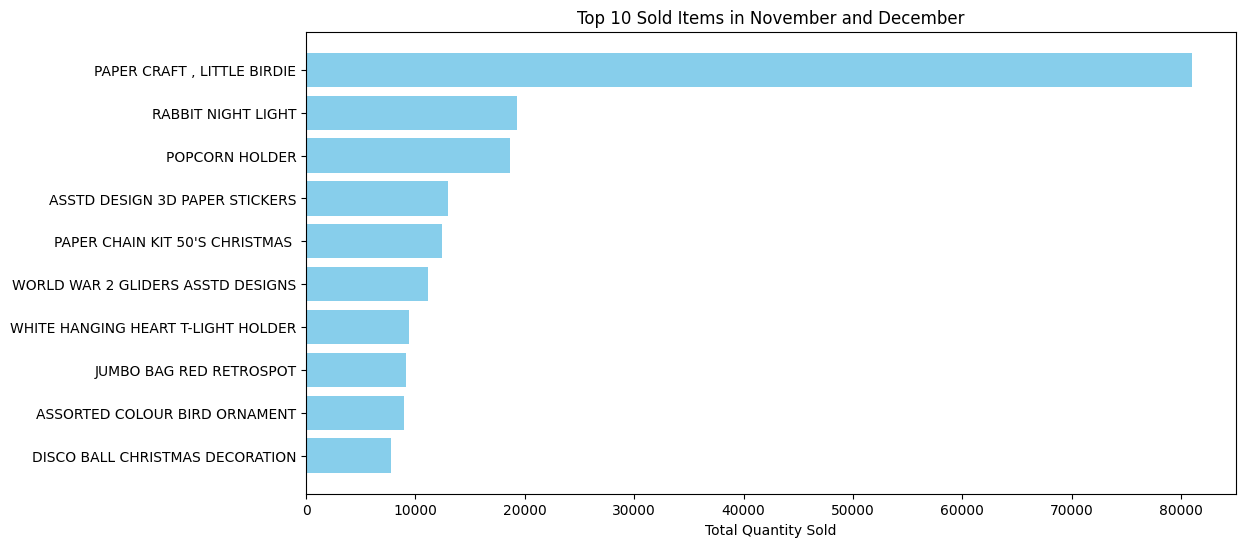

     StockCode                         Description  Quantity
2457     23843         PAPER CRAFT , LITTLE BIRDIE     80995
1910     23084                  RABBIT NIGHT LIGHT     19265
1033     22197                      POPCORN HOLDER     18677
2687     84826      ASSTD DESIGN 3D PAPER STICKERS     13009
923      22086     PAPER CHAIN KIT 50'S CHRISTMAS      12457
2615     84077   WORLD WAR 2 GLIDERS ASSTD DESIGNS     11121
3454    85123A  WHITE HANGING HEART T-LIGHT HOLDER      9417
3443    85099B             JUMBO BAG RED RETROSPOT      9166
2698     84879       ASSORTED COLOUR BIRD ORNAMENT      8955
61       20668     DISCO BALL CHRISTMAS DECORATION      7782


In [257]:
def get_top_10_sold_items_nov_dec(df):
    df_copy = df.copy()
    df_copy['InvoiceDate'] = pd.to_datetime(df_copy['InvoiceDate'])
    df_nov_dec = df_copy[df_copy['InvoiceDate'].dt.month.isin([11, 12])]
    df_grouped = df_nov_dec.groupby(['StockCode', 'Description'])['Quantity'].sum().reset_index()
    top_10_sold_items = df_grouped.sort_values(by='Quantity', ascending=False).head(10)

    plt.figure(figsize=(12, 6))
    plt.barh(top_10_sold_items['Description'], top_10_sold_items['Quantity'], color='skyblue')
    plt.xlabel('Total Quantity Sold')
    plt.title('Top 10 Items Sold in November and December')
    plt.gca().invert_yaxis()
    plt.show()

    return top_10_sold_items[['StockCode', 'Description', 'Quantity']]

top_10_sold_items_nov_dec = get_top_10_sold_items_nov_dec(final_df)
print(top_10_sold_items_nov_dec)


It seems the Paper Craft Little Birdie retains its position, while other, smaller items take 2nd and 3rd place in the rankings, around the holiday season. 
This makes sense in view of the fact that this season is usually when gifts are exchanged between people, which often includes the gifting of small items. 